Load Image,convert to grayscale, Threshold

In [1]:
#import necessary libraries and Modules
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import cv2
from PIL import Image


Thresholded image saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png
(1038, 1042)


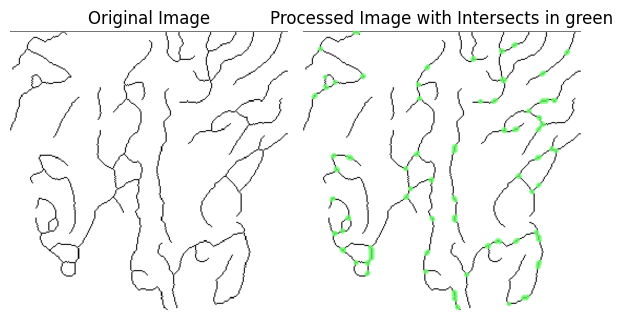

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png
(1038, 1042)


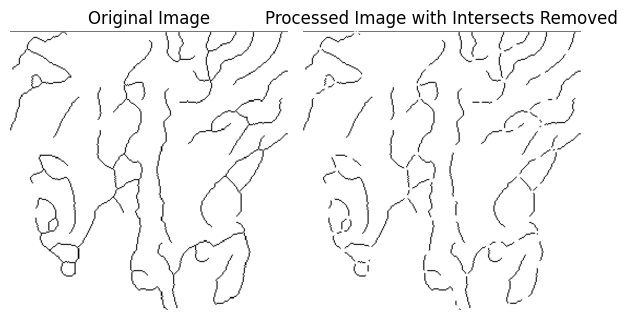

Processed C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png successfully. Saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png


In [2]:
input_image = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1.png'
invert_input = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1Invert.png'
intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThinSkeleton1NoIntersects.png'

IMF.invert_image(input_image, invert_input)
IA.identify_intersects(invert_input, intersects_removed,dot_size=8,box_size=10, perc = .4, RGBA_color = (100, 255, 100, 200), title = 'Processed Image with Intersects in green')
IA.identify_intersects(invert_input, intersects_removed,dot_size=4,box_size=10, perc = .4, RGBA_color = (255, 255, 255, 255), title = 'Processed Image with Intersects Removed')

Thresholded image saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\InvertIntersects.png


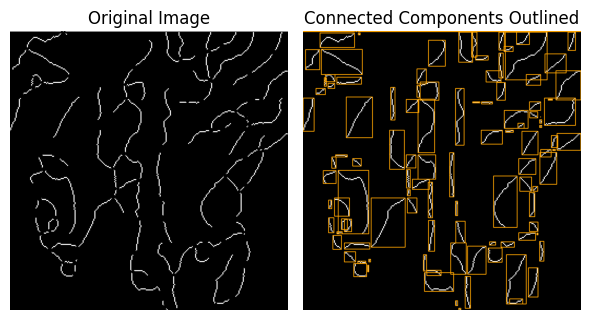

In [4]:
invert_intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\InvertIntersects.png'
IMF.invert_image(intersects_removed ,invert_intersects_removed)
labels, stats = IA.identify_connected_components(invert_intersects_removed)

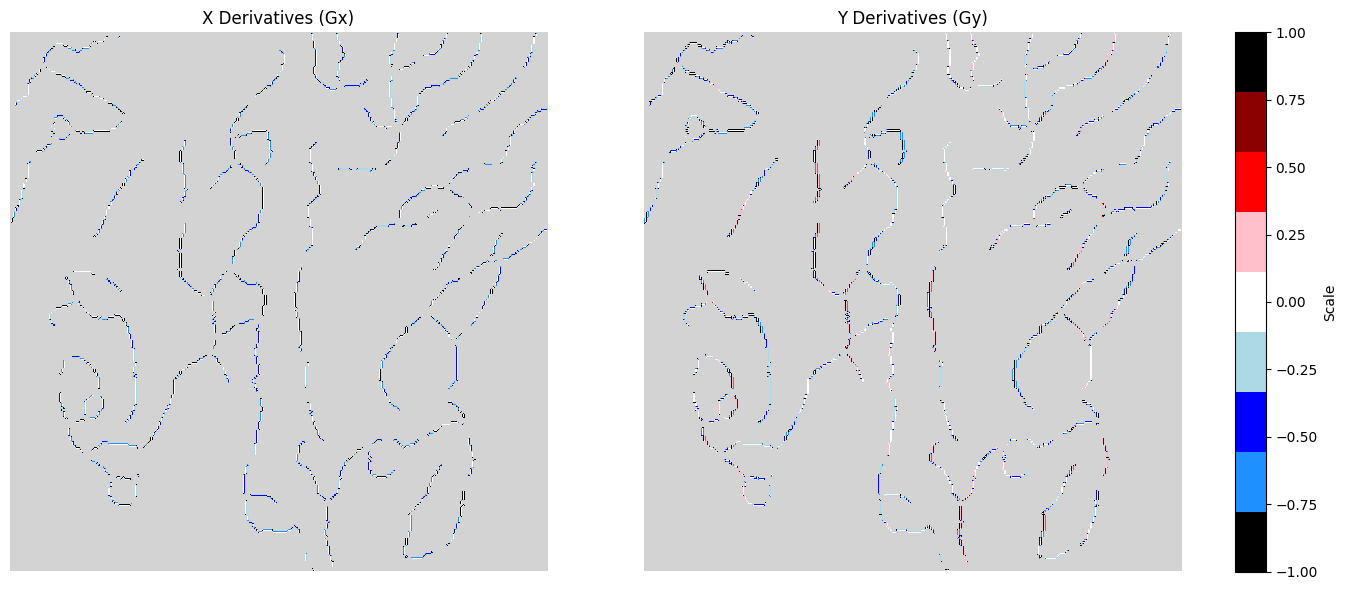

In [4]:
# read the image
img = cv2.imread(intersects_removed)

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# blur
blur = cv2.GaussianBlur(gray, (0,0), 1.3, 1.3)

# apply sobel derivatives
sobelx = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=3)
PF.plot_sobel_derivatives(sobelx, sobely)

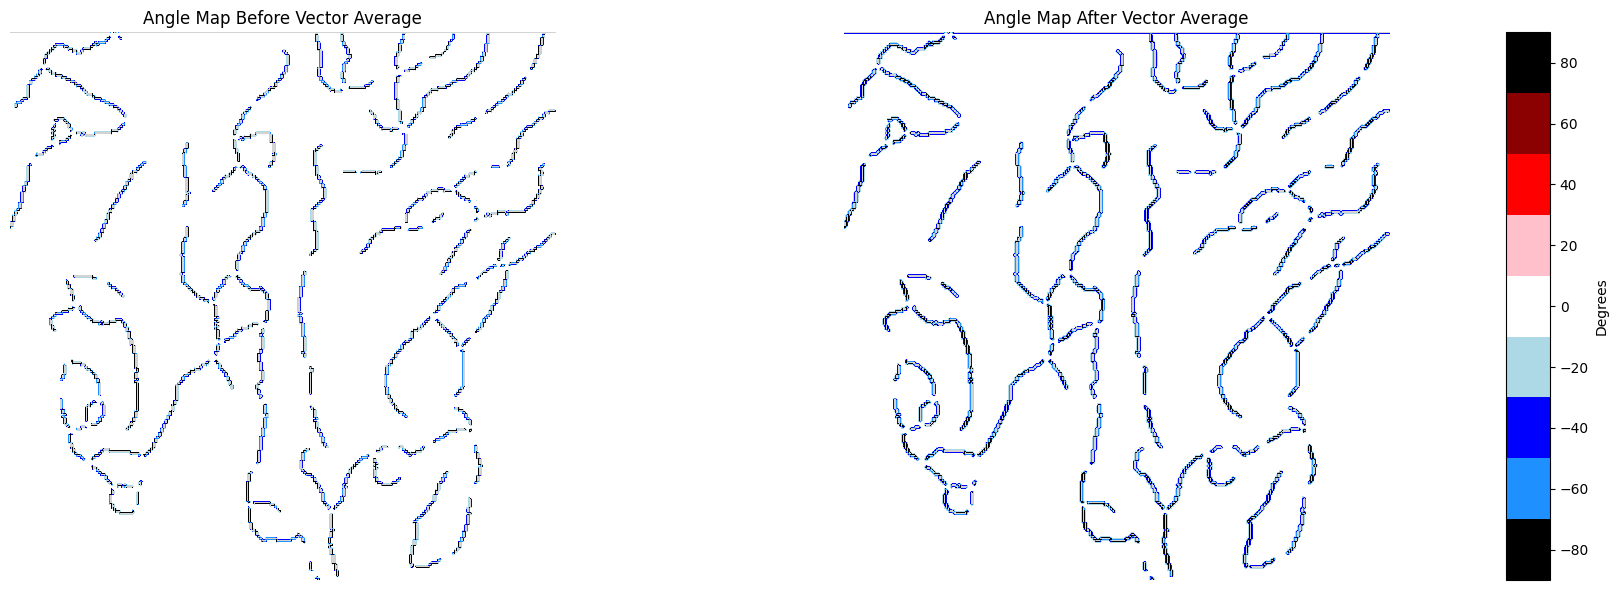

In [5]:
IMF.plot_angle_map(output_image3, Gx_maps, Gy_maps)